# Warm-up example
### Averaging uncorrelated random variables reduces variance!

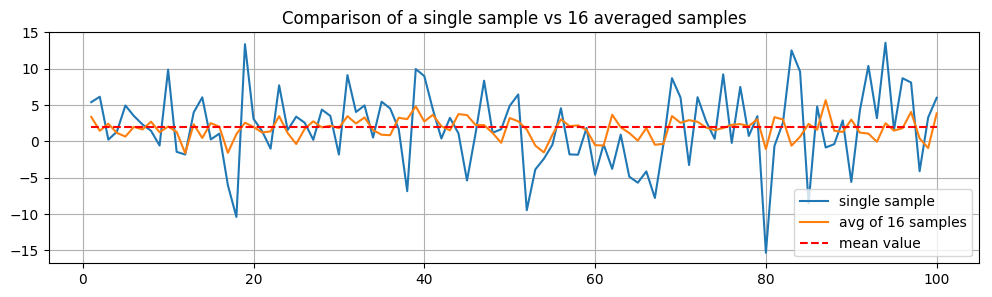

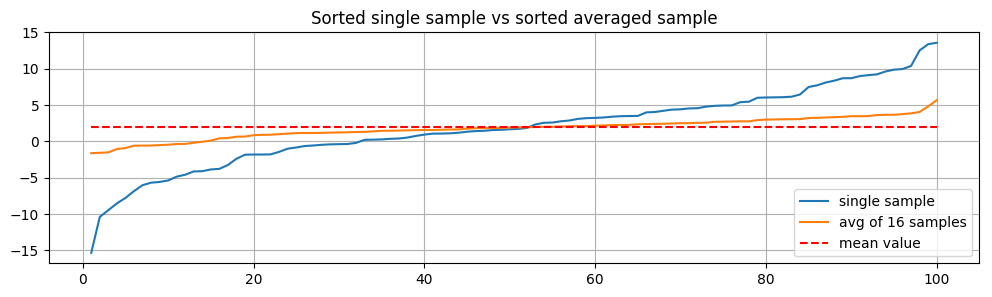

In [13]:
srand(0)
X = 2 + 5*randn(100,16)

using PyPlot

figure(figsize=[12,3])
plot(1:100, X[:,1], 1:100, mean(X,2), 1:100, 2*ones(100), "r--")
legend(["single sample","avg of 16 samples","mean value"],loc="lower right")
title("Comparison of a single sample vs 16 averaged samples")
grid()

figure(figsize=[12,3])
plot(1:100, sort(X[:,1]), 1:100, sort(mean(X,2)[:]), 1:100, 2*ones(100), "r--")
legend(["single sample","avg of 16 samples","mean value"],loc="lower right")
title("Sorted single sample vs sorted averaged sample")
grid()
;

# Portfolio optimization example

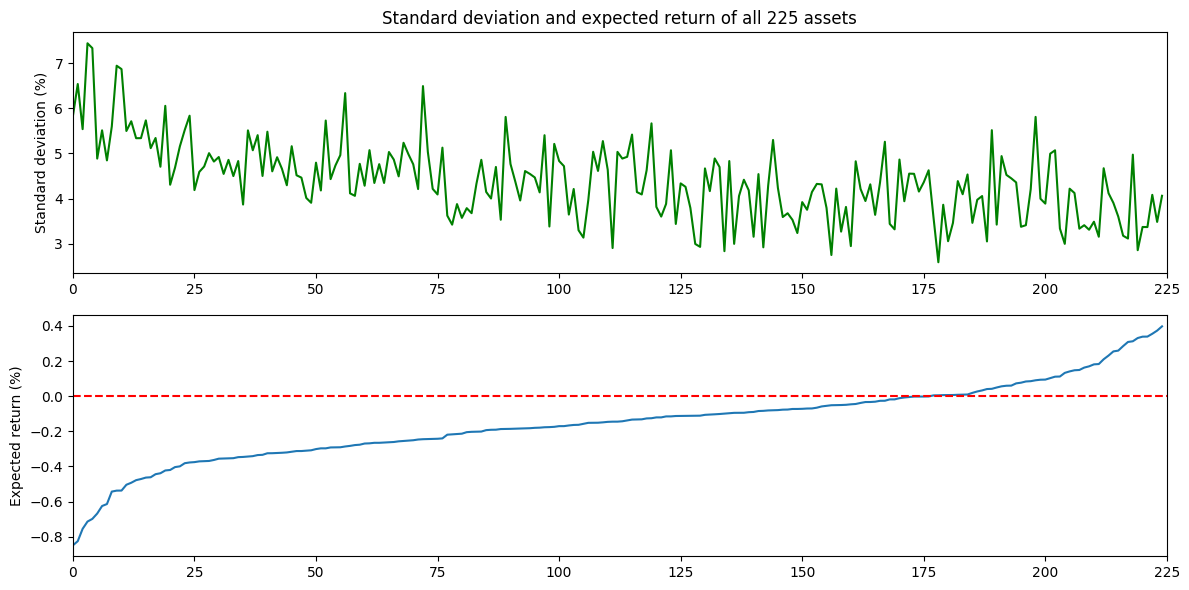

In [15]:
μ = 100*readcsv("folio_mean.csv")[:]   # Expected return (in percent)
Σ = 10000*readcsv("folio_cov.csv")     # Expected variance (in percent squared)

ix = sortperm(μ);   # sort the assets by expected return

using PyPlot
fig = figure(figsize=(12,6))

subplot(211)
xlim(0,225)
plot(sqrt.(diag(Σ))[ix],"g")
ylabel("Standard deviation (%)")
title("Standard deviation and expected return of all 225 assets")
tight_layout()

subplot(212)
xlim(0,225)
plot(μ[ix])
plot([0,225],[0,0],"r--")
ylabel("Expected return (%)")
tight_layout()
#savefig("folio1_vals.pdf")
;

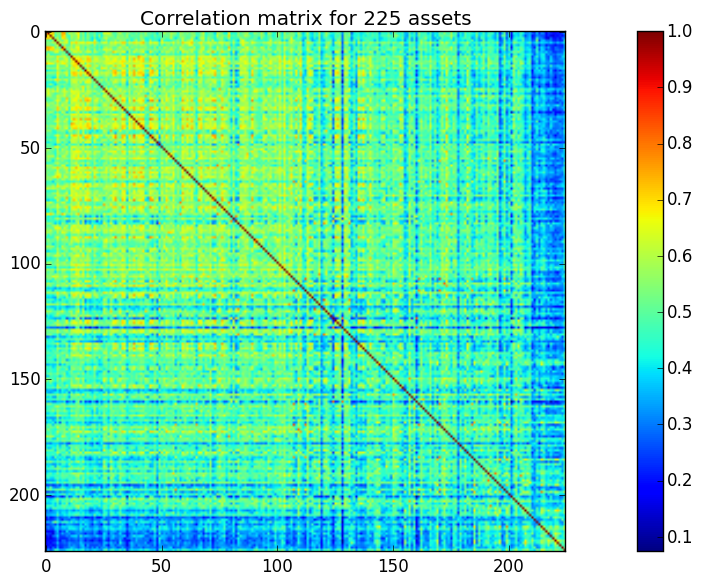

In [4]:
# plot correlation matrix (shows which assets are correlated with which other assets)
corr = diagm(diag(Σ).^(-1/2))*Σ*diagm(diag(Σ).^(-1/2))
imshow(corr[ix,ix]);colorbar();axis("image")
title("Correlation matrix for 225 assets")
tight_layout()
#savefig("folio2_cov.pdf")

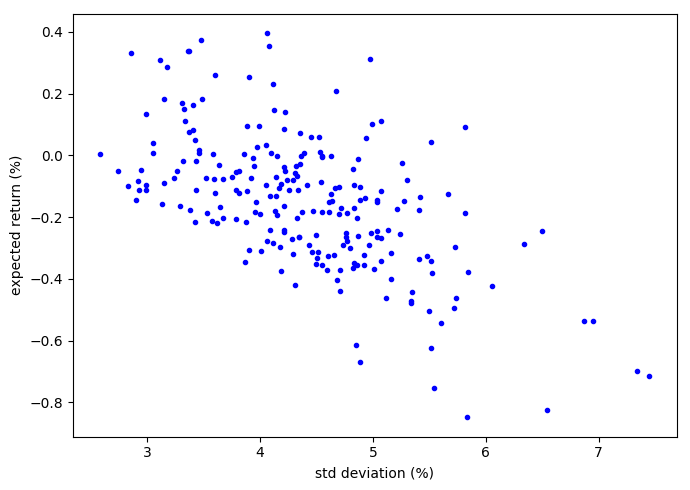

In [17]:
# plot each asset individually
figure(figsize=(7,5))
plot(sqrt.(diag(Σ)), μ, "b.")
xlabel("std deviation (%)")
ylabel("expected return (%)")
tight_layout()
#savefig("folio3_assets.pdf")
;

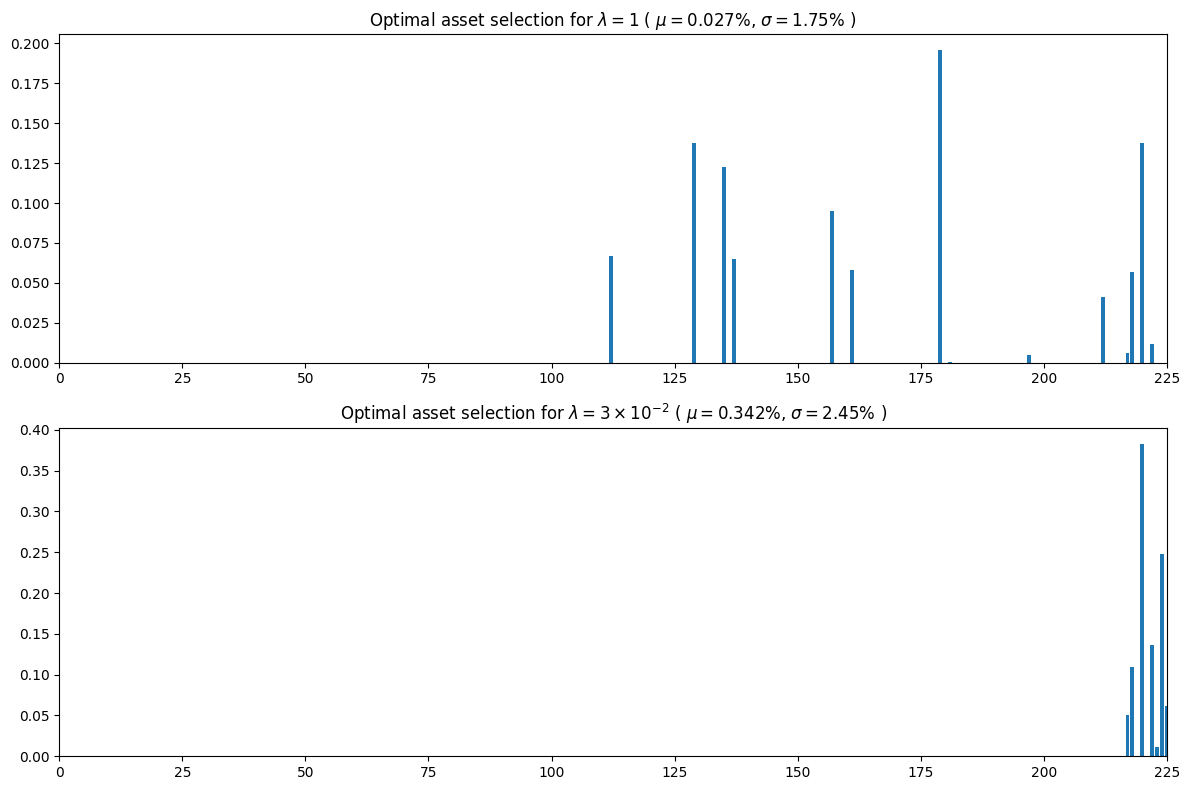

In [18]:
# find optimal portfolio for one particular choice of λ
using JuMP, Mosek
m = Model(solver = MosekSolver(LOG=0))
@variable(m, x[1:225] >= 0)
@constraint(m, sum(x) == 1)

figure(figsize=(12,8))

subplot(211)
λ = 1

@objective(m, Min, -dot(μ,x) + λ*dot(x,Σ*x) )
solve(m)
xsol = getvalue(x)
ix1 = find(xsol .> 1e-4)
ret = dot(μ,xsol)
std = sqrt(dot(xsol,Σ*xsol))
xlim(0,225)
bar(1:225,xsol[ix])
title(string("Optimal asset selection for \$\\lambda=1\$"," ( \$\\mu=\$", round(ret,3), "%, \$\\sigma=\$", round(std,2), "% )"));
tight_layout()
subplot(212)
λ = 3e-2

@objective(m, Min, -dot(μ,x) + λ*dot(x,Σ*x) )
solve(m)
xsol = getvalue(x)
ix2 = find(xsol .> 1e-4)
ret = dot(μ,xsol)
std = sqrt(dot(xsol,Σ*xsol))
xlim(0,225)
bar(1:225,xsol[ix])
title(string("Optimal asset selection for \$\\lambda=3\\times10^\{-2\}\$"," ( \$\\mu=\$", round(ret,3), "%, \$\\sigma=\$", round(std,2), "% )"));
tight_layout()

#savefig("folio4_optassets.pdf")

In [19]:
# compute optimal tradeoff curve (this may take a few seconds)
N = 50
ret = zeros(N)
std = zeros(N)
lambda_values = logspace(-3,4,N)

for (i,λ) in enumerate(lambda_values)
    @objective(m, Min, -dot(μ,x) + λ*dot(x,Σ*x) )
    solve(m)
    xsol = getvalue(x)
    ret[i] = dot(μ,xsol)
    std[i] = sqrt(dot(xsol,Σ*xsol))
end

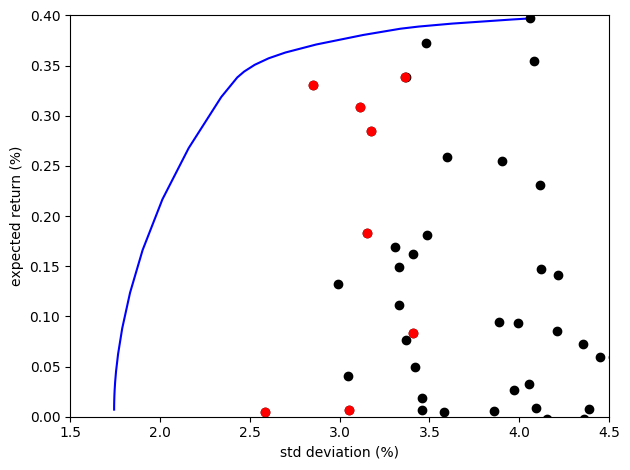

In [24]:
# plot tradeoff curve
plot(std,ret,"b-")
plot(sqrt.(diag(Σ)), μ, "k.", markersize=12)
plot(sqrt.(diag(Σ))[ix1], μ[ix1], "r.", markersize=12)  # low-risk portfolio
#plot(sqrt.(diag(Σ))[ix2], μ[ix2], "r.", markersize=12)  # at the "elbow" of the curve
xlabel("std deviation (%)")
ylabel("expected return (%)")
axis([1.5,4.5,0,.4]);
tight_layout()
#savefig("folio5_pareto.pdf")